### Install Model Trust Repository

## Prerequisites
This notebook assumes that you have 
1. An OpenShift cluster provisioned, OpenShift and Kubectl CLI installed, and kube config (~/.kube/config) file available.
2. Deployed Open Data Hub(ODH) on the OpenShift cluster. 
3. Installed Triton runtime CRD in odh project in the above OpenShift cluster.
4. Created a data science project and workbench following [ODH documentation](https://opendatahub.io/docs/getting-started-with-open-data-hub/#creating-a-data-science-project_get-started)
5. Created a Data Connection using S3/IBM Cloud Object Storage following step 4.
6. Trained and serialized a regression model (base model) using ONNX. And uploaded the ONNX serialized base model to S3.
7. Uploaded calibration dataset to S3. Calibration dataset is a dataset closer to train data but not used in training (Fit or Cross validation) of the base model.
8. Uploaded test dataset to S3.



In [1]:
import os

if not os.path.exists("trustyai-model-trust"):
    !git clone https://github.com/trustyai-explainability/trustyai-model-trust

In [2]:
!pip install trustyai-model-trust/[deploy,infer]

Processing ./trustyai-model-trust
  Preparing metadata (setup.py) ... done
  Created wheel for model-trust: filename=model_trust-0.0.1-py3-none-any.whl size=26751 sha256=fcc5608d51ef1ba2db405259801088b5454ab563b6d09ade1db1ea027c621cf6
  Stored in directory: /tmp/pip-ephem-wheel-cache-r6iqvec3/wheels/70/c7/e0/ac890070dac83e6b26e3089662857ce01b09ae4cad2bd505d6
Successfully built model-trust
  Attempting uninstall: model-trust
    Found existing installation: model-trust 0.0.1
    Uninstalling model-trust-0.0.1:
      Successfully uninstalled model-trust-0.0.1

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


### Imports

In [3]:
import os
import json
import boto3
import onnx
import warnings
import numpy as np
import pandas as pd
from joblib import dump
import onnxruntime as rt
import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from model_trust.datasets.synthetic_data import load_linear_2_region_data
from model_trust.regression.region_uncertainty_estimation import RegionUncertaintyEstimator

warnings.filterwarnings("ignore")

### Load Data

In [4]:
# s3 connection
session = boto3.Session(
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
)
s3_client = session.client('s3',
                    endpoint_url=os.getenv("AWS_ENDPOINT_URL"),
                    region_name=os.getenv("AWS_REGION"),
)
base_model_bucket = "model-trust" # s3 bucket with base model

Load test dataset

In [5]:
x_test = pd.read_csv(s3_client.get_object(Bucket=base_model_bucket, Key="simulated_data/x_test.csv")['Body'])
y_test = pd.read_csv(s3_client.get_object(Bucket=base_model_bucket, Key="simulated_data/y_test.csv")['Body'])
x_test = x_test.values
y_test = y_test.values.flatten()
print(x_test.shape)
print(y_test.shape)

(600, 1)
(600,)


Load calibration dataset

In [6]:
x_cal = pd.read_csv(s3_client.get_object(Bucket=base_model_bucket, Key="simulated_data/x_cal.csv")['Body'])
y_cal = pd.read_csv(s3_client.get_object(Bucket=base_model_bucket, Key="simulated_data/y_cal.csv")['Body'])
x_cal = x_cal.values
y_cal = y_cal.values.flatten()
print(x_cal.shape)
print(y_cal.shape)

(480, 1)
(480,)


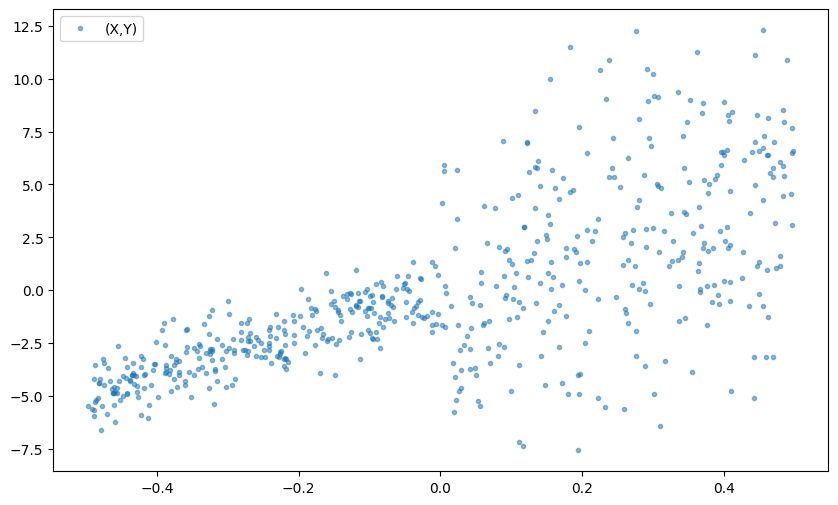

In [7]:
import matplotlib.pyplot as plt

x_test_sort = np.sort(x_test.flatten())
x_test_sort_indices = np.argsort(x_test.flatten())


plt.rcParams["figure.figsize"] = (10, 6)

plt.plot(x_test_sort, y_test[x_test_sort_indices], '.', alpha = 0.5, label='(X,Y)')

plt.legend(loc='upper left', bbox_to_anchor=(0, 1.0))
plt.show()

### Download Base Model From S3

In [8]:

base_model_path = "onnx_models/base_onnx_model.onnx" # model path within the s3 bucket

base_onnx_model_str = s3_client.get_object(Bucket=base_model_bucket, Key=base_model_path)['Body'].read()
base_onnx_model_str

b'\x08\x08\x12\x08skl2onnx\x1a\x061.15.0"\x07ai.onnx(\x002\x00:\xb0\x01\ni\n\x01X\x12\x08variable\x1a\x0fLinearRegressor"\x0fLinearRegressor*\x16\n\x0ccoefficients=\xbcC!A\xa0\x01\x06*\x14\n\nintercepts=\x1e\xec\xdc<\xa0\x01\x06:\nai.onnx.ml\x12\x16ONNX(LinearRegression)Z\x11\n\x01X\x12\x0c\n\n\x08\x01\x12\x06\n\x00\n\x02\x08\x01b\x18\n\x08variable\x12\x0c\n\n\x08\x01\x12\x06\n\x00\n\x02\x08\x01B\x0e\n\nai.onnx.ml\x10\x01B\x04\n\x00\x10\x11'

In [9]:
sess = rt.InferenceSession(base_onnx_model_str)
sess.run(None, {"X": x_test[0:10].astype(np.float32)})[0].flatten().shape

(10,)

In [10]:
# y_pred_cal = base_model.predict(x_cal)
y_pred_cal = sess.run(None, {"X": x_cal.astype(np.float32)})[0].flatten()

### Train and Prepare Model Trust Model

In [11]:
multi_region_cp_inputs = {}
multi_region_cp_inputs['confidence'] = 95 # 0.95 quantile
multi_region_cp_inputs['regions_model'] = "multi_region"
multi_region_cp_inputs['base_model'] = base_onnx_model_str

# region parameters
multi_region_cp_inputs["multi_region_model_selection_metric"] = "coverage_ratio"
multi_region_cp_inputs["multi_region_model_selection_stat"] = "min"
multi_region_cp_inputs["multi_region_min_group_size"] = 20

multi_region_cp_model = RegionUncertaintyEstimator(**multi_region_cp_inputs)

In [12]:
%time multi_region_cp_model.fit(x_cal, y_cal)

Best Params :{'min_samples_leaf': 100, 'ccp_alpha': 0.0005, 'max_depth': 2, 'random_state': 42}
Best model :DecisionTreeRegressor(ccp_alpha=0.0005, max_depth=2, min_samples_leaf=100,
                      random_state=42)
CPU times: user 3min 53s, sys: 1.33 s, total: 3min 54s
Wall time: 1min 58s


### Upload Model Trust Model To COS

In [13]:
model_trust_wrapped_model = multi_region_cp_model.export_learned_config()['combined_model']
model_trust_wrapped_model

b'\x08\x08\x12\x19onnx.compose.merge_models\x1a\x031.0"\x00(\x01:\xd1\x0f\nt\n\x01X\x12\x13base_model_variable\x1a\x0fLinearRegressor"\x0fLinearRegressor*\x16\n\x0ccoefficients=\xbcC!A\xa0\x01\x06*\x14\n\nintercepts=\x1e\xec\xdc<\xa0\x01\x06:\nai.onnx.ml\n\x15\n\x01X\x12\x06x_orig"\x08Identity\n\x96\x05\n\x01X\x12\x08variable\x1a\x15TreeEnsembleRegressor"\x15TreeEnsembleRegressor*\x10\n\tn_targets\x18\x01\xa0\x01\x02*%\n\x12nodes_falsenodeids@\x04@\x03@\x00@\x00@\x06@\x00@\x00\xa0\x01\x07*#\n\x10nodes_featureids@\x00@\x00@\x00@\x00@\x00@\x00@\x00\xa0\x01\x07*6\n\x0enodes_hitrates=\x00\x00\x80?=\x00\x00\x80?=\x00\x00\x80?=\x00\x00\x80?=\x00\x00\x80?=\x00\x00\x80?=\x00\x00\x80?\xa0\x01\x06*2\n\x1fnodes_missing_value_tracks_true@\x00@\x00@\x00@\x00@\x00@\x00@\x00\xa0\x01\x07*L\n\x0bnodes_modesJ\nBRANCH_LEQJ\nBRANCH_LEQJ\x04LEAFJ\x04LEAFJ\nBRANCH_LEQJ\x04LEAFJ\x04LEAF\xa0\x01\x08* \n\rnodes_nodeids@\x00@\x01@\x02@\x03@\x04@\x05@\x06\xa0\x01\x07* \n\rnodes_treeids@\x00@\x00@\x00@\x00@\x00@\

In [14]:
# upload Model Trust model to S3
model_trust_wrapped_model_path = "onnx_models/multi_region_model_trust_model.onnx"
s3_client.put_object(Body=model_trust_wrapped_model, Bucket=base_model_bucket, Key=model_trust_wrapped_model_path)


{'ResponseMetadata': {'RequestId': '2a92eecf-35d1-400d-bb06-e76c652ad6d8',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 15 Dec 2023 06:15:12 GMT',
   'x-clv-request-id': '2a92eecf-35d1-400d-bb06-e76c652ad6d8',
   'server': 'Cleversafe',
   'x-clv-s3-version': '2.5',
   'x-amz-request-id': '2a92eecf-35d1-400d-bb06-e76c652ad6d8',
   'etag': '"87142789dad525ae2653562c2659d06e"',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"87142789dad525ae2653562c2659d06e"'}

### Deploy Model Trust Wrapped Model From S3 on Model Mesh

By this time, you might have created a s3 data connection in ODH. If not, create a data connection following [ODH Docs](https://opendatahub.io/docs/getting-started-with-open-data-hub/). Then, obtain the data connection resource name by clicking on "?" next to data connection name. It would be similar to "aws-connection-s3store".

In [15]:
from kubernetes import client

from kserve import KServeClient
from kserve import constants
from kserve import V1beta1PredictorSpec, V1beta1Batcher
from kserve import V1beta1ModelSpec, V1beta1ModelFormat
from kserve import V1beta1StorageSpec
from kserve import V1beta1InferenceServiceSpec
from kserve import V1beta1InferenceService

service_name = "trust-single-region-cos-model-4"
project_name = "model-trust-ds-project"
s3_resource_name = "aws-connection-tsfmcos"

default_model_spec = V1beta1InferenceServiceSpec(predictor=V1beta1PredictorSpec(model=V1beta1ModelSpec(model_format=V1beta1ModelFormat(name="onnx"), 
                                                                                                       runtime="triton-2.x", 
                                                                                                      storage=V1beta1StorageSpec(key=s3_resource_name, path=model_trust_wrapped_model_path)),
                                                                               batcher=V1beta1Batcher(max_batch_size=100)))

isvc = V1beta1InferenceService(api_version=constants.KSERVE_V1BETA1,
                          kind=constants.KSERVE_KIND,
                          metadata=client.V1ObjectMeta(name=service_name, 
                                                       namespace=project_name, 
                                                       annotations={"serving.kserve.io/deploymentMode": "ModelMesh"}),
                          spec=default_model_spec)


kserve_client = KServeClient(config_file='./config')

# create inference service
kserve_client.create(isvc)
# isvc

{'apiVersion': 'serving.kserve.io/v1beta1',
 'kind': 'InferenceService',
 'metadata': {'annotations': {'serving.kserve.io/deploymentMode': 'ModelMesh'},
  'creationTimestamp': '2023-12-15T06:15:13Z',
  'generation': 1,
  'managedFields': [{'apiVersion': 'serving.kserve.io/v1beta1',
    'fieldsType': 'FieldsV1',
    'fieldsV1': {'f:metadata': {'f:annotations': {'.': {},
       'f:serving.kserve.io/deploymentMode': {}}},
     'f:spec': {'.': {},
      'f:predictor': {'.': {},
       'f:batcher': {'.': {}, 'f:maxBatchSize': {}},
       'f:model': {'.': {},
        'f:modelFormat': {'.': {}, 'f:name': {}},
        'f:name': {},
        'f:runtime': {},
        'f:storage': {'.': {}, 'f:key': {}, 'f:path': {}}}}}},
    'manager': 'OpenAPI-Generator',
    'operation': 'Update',
    'time': '2023-12-15T06:15:13Z'}],
  'name': 'trust-single-region-cos-model-4',
  'namespace': 'model-trust-ds-project',
  'resourceVersion': '40258583',
  'uid': '5a0aac63-efd1-4ef8-adb5-1229799f21a9'},
 'spec': {

In [17]:
if not kserve_client.is_isvc_ready(service_name, namespace=project_name):
    kserve_client.wait_isvc_ready(name=service_name, namespace=project_name, timeout_seconds=5)

kserve_client.is_isvc_ready(service_name, namespace=project_name)

True

Find route created for the deployed model.

In [18]:
import openshift as oc

oc.set_default_kubeconfig_path("./config")

In [19]:
service_route = oc.selector("route.route.openshift.io/{}".format(service_name)).object(ignore_not_found=True)
if not service_route:
    print("Route is not created for the model. Deployment might have failed. Please check the deployment configuration again...")
    

In [20]:
service_route_dict = service_route.as_dict()
model_inference_path = "https://" + service_route_dict["spec"]["host"] + service_route_dict["spec"]["path"] + "/infer"
model_inference_path

'https://trust-single-region-cos-model-4-model-trust-ds-project.apps.odhnewcluster1.cp.fyre.ibm.com/v2/models/trust-single-region-cos-model-4/infer'

Infer single instance

In [21]:
test_data = x_test[0:1]

req_data = {"inputs": [{
  "name" : "X",
  "shape" : list(test_data.shape),
  "datatype"  : "FP32",
  "data" : test_data.tolist()
    }]
}


In [22]:
import requests

requests.post(model_inference_path, json=req_data, verify=False).json()

{'model_name': 'trust-single-region-cos-model-4__isvc-a89b7cb37f',
 'model_version': '1',
 'outputs': [{'name': 'exp_lower_pred_endpoint',
   'datatype': 'FP32',
   'shape': [1, 1],
   'data': [-6.6394157]},
  {'name': 'exp_upper_pred_endpoint',
   'datatype': 'FP32',
   'shape': [1, 1],
   'data': [11.481062]},
  {'name': 'input_x',
   'datatype': 'FP32',
   'shape': [1, 1],
   'data': [0.23750836]},
  {'name': 'prediction',
   'datatype': 'FP32',
   'shape': [1, 1],
   'data': [2.4208233]},
  {'name': 'region_model_prediction',
   'datatype': 'FP32',
   'shape': [1, 1],
   'data': [6.3835335]}]}

Infer multiple instances

In [23]:
test_data = x_test[0:4]

req_data = {"inputs": [{
  "name" : "X",
  "shape" : list(test_data.shape),
  "datatype"  : "FP32",
  "data" : test_data.tolist()
    }]
}

In [24]:
import requests

requests.post(model_inference_path, json=req_data, verify=False).json()

{'model_name': 'trust-single-region-cos-model-4__isvc-a89b7cb37f',
 'model_version': '1',
 'outputs': [{'name': 'exp_lower_pred_endpoint',
   'datatype': 'FP32',
   'shape': [4, 1],
   'data': [-6.6394157, -6.4090767, -6.319761, -3.209134]},
  {'name': 'exp_upper_pred_endpoint',
   'datatype': 'FP32',
   'shape': [4, 1],
   'data': [11.481062, -2.2583656, 11.800716, 0.94686174]},
  {'name': 'input_x',
   'datatype': 'FP32',
   'shape': [4, 1],
   'data': [0.23750836, -0.4326494, 0.26922315, -0.11490227]},
  {'name': 'prediction',
   'datatype': 'FP32',
   'shape': [4, 1],
   'data': [2.4208233, -4.333721, 2.740478, -1.1311362]},
  {'name': 'region_model_prediction',
   'datatype': 'FP32',
   'shape': [4, 1],
   'data': [6.3835335, 1.7287105, 6.3835335, 1.6521276]}]}

### Delete Model Deployment From Model Mesh

In [25]:
kserve_client = KServeClient(config_file='./config')

In [26]:
kserve_client.delete(service_name, namespace=project_name)

{'kind': 'Status',
 'apiVersion': 'v1',
 'metadata': {},
 'status': 'Success',
 'details': {'name': 'trust-single-region-cos-model-4',
  'group': 'serving.kserve.io',
  'kind': 'inferenceservices',
  'uid': '5a0aac63-efd1-4ef8-adb5-1229799f21a9'}}

In [27]:
try:
    kserve_client.get(service_name, namespace=project_name)
except:
    print("Model deployment {} does not exist".format(service_name))

Model deployment trust-single-region-cos-model-4 does not exist
